# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Exploratory Analysis](#analysis)
* [Machine Learning](#ML)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

I have recently discussed with investors the idea of designing and creating a new website which will allow to compare eateries between two major cities. We will be using New York and Toronto as pilot. The main idea of this website would be to score each city on several factors and compare how similar or dissimilar eateries are between them. Eateries would include Restaurants and cafes serving food.
Similarity between the 2 cities will be analyze by measuring the following range factor: diversity (style, origin), accessibility (distance to transport ) ,cost , quality (rating) and density (population/eateries)


## Data <a name="data"></a>

We will need the following data to answer the business questions.

Eateries Name, addresses and associated coordinates will be extracted from https://foursquare.com
Eateries style, origin (diversity), cost and quality (rating) will also be extracted from https://foursquare.com
Accessibility (transportation coordinates ) will be extracted from https://data.ny.gov/widgets/i9wp-a4ja for New York and http://scruss.com/blog/2005/12/14/toronto-subway-station-gps-locations/ for Toronto.
Finally for density we will extract borough density from https://en.wikipedia.org/wiki/Demographics_of_New_York_City for New York and https://en.wikipedia.org/wiki/Greater_Toronto_Area for Toronto.


In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from folium.plugins import FastMarkerCluster, MarkerCluster
print('Folium installed')
print('Libraries imported.')

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Solving environment: | 

### Extracting and formating data from Foursquare

In [3]:
CLIENT_ID = '5DF0SUHJHNTIYJQZRRDQTPFZBF3L4MG1BPX14MUTWOGECNSQ' # your Foursquare ID
CLIENT_SECRET = 'BHAFZLAHSXXXUPUQJSY0OJISSCJOULN2KHHG41ORN0POBOUV' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
search_query = 'restaurant'
radius = 5000

In [6]:
def func_Cost_Rating(venue_id):
    # = IDs 
    url2 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    results2 = requests.get(url2).json()
    try:
        Cost.append(results2['response']['venue']['price']['message'])
        Rating.append(results2['response']['venue']['rating'])
    except:
        Cost.append("No Cost")
        Rating.append("No Rating")

In [7]:
def func_Venue(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    i=0
    while i<(len(results['response']['groups'][0]["items"])):
        Name.append(results['response']['groups'][0]["items"][i]["venue"]["name"])
        ID.append(results['response']['groups'][0]["items"][i]["venue"]["id"])
        
        #Calling Function to retrieve from foursqare the cost and rating of each restaurant
        func_Cost_Rating(results['response']['groups'][0]["items"][i]["venue"]["id"])
        
        Latitude.append(results['response']['groups'][0]["items"][i]["venue"]["location"]["lat"])
        Longitude.append(results['response']['groups'][0]["items"][i]["venue"]["location"]["lng"])
        Distance.append(results['response']['groups'][0]["items"][i]["venue"]["location"]["distance"])
        Category.append(results['response']['groups'][0]["items"][i]["venue"]["categories"][0]["shortName"])
        try:
            Address.append(results['response']['groups'][0]["items"][i]["venue"]["location"]["address"])
        except:
            Address.append("No address Code")
        try:
            PostalCode.append(results['response']['groups'][0]["items"][i]["venue"]["location"]["postalCode"])
        except:
            PostalCode.append("No Postal Code")
                
        i=i+1

In [14]:
Name=[]
Category=[]
Address=[]
ID=[]
Latitude=[]
Longitude=[]
PostalCode=[]
Distance=[]
Cost=[]
Rating=[]


func_Venue('New York, NY')




print("Transaction is complete")

Transaction is complete


In [15]:
df=pd.DataFrame()
df['Name']=Name
df['Category']=Category
df['Address']=Address 
df['Latitude']=Latitude
df['Longitude']=Longitude
df['PostalCode']=PostalCode
df['Distance']=Distance
df['ID']=ID
df['Cost']=Cost
df['Rating']=Rating
df = df.drop_duplicates()
df.reset_index(drop=True)
df.head()

,Name,Category,Address,Latitude,Longitude,PostalCode,Distance,ID,Cost,Rating
0,Momofuku Ssäm Bar,Asian,207 2nd Ave,40.731711,-73.985571,10003,163,4acca438f964a5201dc920e3,Expensive,9.3
1,Shake Shack,Burgers,51 Astor Pl,40.729998,-73.989696,10003,234,59d36de20fe7a024363de0b8,Cheap,9.3
2,Han Dynasty,Chinese,90 3rd Ave,40.732130,-73.988090,10003,161,52169fba11d21db81bdab2a0,Moderate,9.2
3,Ippudo,Ramen,65 4th Ave,40.730835,-73.990622,10003,292,4a5403b8f964a520f3b21fe3,Moderate,9.4
4,Joe's Pizza,Pizza,150 E 14th St,40.733300,-73.987631,10003,274,51351c3fe4b0c58b63965114,Cheap,9.3


### Exporting and formating Subway data into a dataframe 

 A. New York

In [11]:
df1 = pd.read_csv("NY_SUBWAY.csv")
df1.head()

,URL,OBJECTID,NAME,the_geom,LINE,NOTES
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights"
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times"
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times"


In [12]:
df1 = df1.drop(["URL", "OBJECTID","LINE", "NOTES"], axis=1)
df1['the_geom']=df1.loc[ : , 'the_geom' ].str.replace("POINT","")
df1['the_geom']=df1.loc[ : , 'the_geom' ].str.replace("(","")
df1['the_geom']=df1.loc[ : , 'the_geom' ].str.replace(")","")
dt_NewYork_Subway= df1.join(df1['the_geom'].str.split(' ', expand=True).add_prefix('sec'))
dt_NewYork_Subway= dt_NewYork_Subway.drop(["the_geom", "sec0"], axis=1)
dt_NewYork_Subway = dt_NewYork_Subway.rename(columns={"sec2": "Latitude","sec1": "Longitude","NAME": "Station"})
dt_NewYork_Subway['Longitude'] = dt_NewYork_Subway['Longitude'].astype(float)
dt_NewYork_Subway['Latitude'] = dt_NewYork_Subway['Latitude'].astype(float)
dt_NewYork_Subway.head()

,Station,Longitude,Latitude
0,Astor Pl,-73.991070,40.730054
1,Canal St,-74.000193,40.718803
2,50th St,-73.983849,40.761728
3,Bergen St,-73.974999,40.680862
4,Pennsylvania Ave,-73.894886,40.664714


In [ ]:
export_csv = dt_NewYork_Subway.to_csv (r'NY_SUBWAY_List.csv', index = None, header=True)

 B. Toronto

In [13]:
dt_Toronto_Subway = pd.read_csv("Toronto_SUBWAY.csv")
dt_Toronto_Subway.head()

,Latitude,Longitude,Station
0,43.638020,-79.536388,Kipling
1,43.645950,-79.523948,Islington
2,43.648804,-79.511541,Royal York
3,43.650576,-79.495225,Old Mill
4,43.650291,-79.484772,Jane


###  Calculating and adding to the dataframe the distance for each restaurant to nearest subway station

In [17]:
import math

In [18]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c*1000
    return km

In [30]:
myList = []
for index, row in df.iterrows():
    lat1=df.loc[index]["Latitude"]
    lon1=df.loc[index]["Longitude"]
    
    for index2, row in dt_NewYork_Subway.iterrows():
        lat2=dt_NewYork_Subway.iloc[index2]["Latitude"]
        lon2=dt_NewYork_Subway.iloc[index2]["Longitude"]
        distance=haversine(lat1,lon1,lat2,lon2)
        myList.append(distance)
    
    df.loc[index,'Distance']=format(round(min(myList)),'.0f')
    myList = []
    
df.head()

,Name,Category,Address,Latitude,Longitude,PostalCode,Distance,ID,Cost,Rating
0,Momofuku Ssäm Bar,Asian,207 2nd Ave,40.731711,-73.985571,10003,36,4acca438f964a5201dc920e3,Expensive,9.3
1,Shake Shack,Burgers,51 Astor Pl,40.729998,-73.989696,10003,146,59d36de20fe7a024363de0b8,Cheap,9.3
2,Han Dynasty,Chinese,90 3rd Ave,40.732130,-73.988090,10003,221,52169fba11d21db81bdab2a0,Moderate,9.2
3,Ippudo,Ramen,65 4th Ave,40.730835,-73.990622,10003,55,4a5403b8f964a520f3b21fe3,Moderate,9.4
4,Joe's Pizza,Pizza,150 E 14th St,40.733300,-73.987631,10003,210,51351c3fe4b0c58b63965114,Cheap,9.3


### Calculating and adding to the dataframe the density for each restaurant 

In [107]:
df_density= pd.read_csv("NY Density per postal code.csv")
df_density.head()


,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank
0,1,10162,"40.769298, -73.949942","New York, New York","1,726",151834.77,#1
1,2,10028,"40.776865, -73.954721","New York, New York","44,987",126067.69,#2
2,3,10128,"40.781656, -73.950281","New York, New York","59,856",122356.52,#3
3,4,10031,"40.825857, -73.949451","New York, New York","60,221",101100.03,#5
4,5,10009,"40.726622, -73.978955","New York, New York","58,595",100687.04,#6


In [113]:
df_density.rename(columns={'People / Sq. Mile':'Density'}, inplace=True)
df_density['Density'] = df_density['Density'].astype(float)
for index3, row in df_density.iterrows():
    Den=df_density.loc[index3]["Density"]
    DenKm= format(round(((df_density.loc[index3]["Density"])/2.58998811)),'.0f')   
    df_density.loc[index3,'Density']=DenKm
    
df_density['Zip Code']=df_density['Zip Code'].astype(str)

for index, row in df.iterrows():
    zip=df.loc[index]["PostalCode"]
    for index2, row in df_density.iterrows():
        if df_density.loc[index2,"Zip Code"]==zip:
            df.loc[index,'People/km2']=df_density.loc[index2,"Density"]
            

df.head()

,Name,Category,Address,Latitude,Longitude,PostalCode,Distance,ID,Cost,Rating,People/km2
0,Momofuku Ssäm Bar,Asian,207 2nd Ave,40.731711,-73.985571,10003,36,4acca438f964a5201dc920e3,Expensive,9.3,5368
1,Shake Shack,Burgers,51 Astor Pl,40.729998,-73.989696,10003,146,59d36de20fe7a024363de0b8,Cheap,9.3,5368
2,Han Dynasty,Chinese,90 3rd Ave,40.732130,-73.988090,10003,221,52169fba11d21db81bdab2a0,Moderate,9.2,5368
3,Ippudo,Ramen,65 4th Ave,40.730835,-73.990622,10003,55,4a5403b8f964a520f3b21fe3,Moderate,9.4,5368
4,Joe's Pizza,Pizza,150 E 14th St,40.733300,-73.987631,10003,210,51351c3fe4b0c58b63965114,Cheap,9.3,5368


### Export Dataframe to csv file

In [ ]:
export_csv = dt.to_csv (r'Total_Restaurants.csv', index = None, header=True)

## Methodology <a name="methodology"></a>

## Exploratory Analysis <a name="analysis"></a>

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

from IPython.display import Image 
from IPython.core.display import HTML 
    
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from folium.plugins import FastMarkerCluster, MarkerCluster
print('Folium installed')
print('Libraries imported.')

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  conda                      pkgs/main::conda-4.6.12-py37_1 --> conda-forge::conda-4.6.12-py37_2


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Folium installed
Libraries imported.
Matplotlib version:  3.0.2


In [112]:
df = pd.read_csv("Total_Restaurants.csv")
dt_subway= pd.read_csv("NY_SUBWAY_List.csv")
dtt = pd.read_csv("Toronto_SUBWAY_List.csv")

df.set_index("Location", inplace=True)
df_n=df.loc['New York']
df_t=df.loc['Toronto']
df=df.reset_index()
df_t=df_t.reset_index()
df_n=df_n.reset_index()


df.head()

,Location,Name,Category,Address,Latitude,Longitude,PostalCode,ID,Cost,Rating,Distance,People/km2,Borough
0,New York,Del Frisco's Double Eagle Steakhouse,Steakhouse,1221 Avenue of the Americas,40.759410,-73.982220,10020,4b0c24fef964a520be3723e3,4,9.3,102,14.0,Manhattan
1,New York,Artie's Steak and Seafood,Italian,394 City Island Ave,40.849542,-73.787317,10464,4514ed4df964a520e5391fe3,4,8.1,4268,536.0,Bronx
2,New York,City Island Diner,Cafe/Diner,304 City Island Ave,40.847238,-73.786245,10464,4b87d10cf964a5206ecd31e3,1,8.1,4188,536.0,Bronx
3,New York,Seafood City,Seafood,459 City Island Ave,40.850967,-73.789778,10464,4aa04654f964a520f33e20e3,2,8.4,4264,536.0,Bronx
4,New York,Kennedy's,American,406 Bayside,40.561360,-73.920932,11697,4b92907ef964a520c00434e3,2,8.0,3128,784.0,Brooklyn


### Foliom map of New York Restaurants and Subway stations 

In [108]:
address = 'New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_NewYork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Station in zip(dt_subway['Latitude'], dt_subway['Longitude'], dt_subway['Station']):
    label = '{}'.format(Station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NewYork) 
    
# add markers to map
for lat, lng, Name in zip(df_n['Latitude'], df_n['Longitude'], df_n['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NewYork)  
    
map_NewYork

### Foliom map of Toronto Restaurants and Subway stations 

In [111]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Station in zip(dtt['Latitude'], dtt['Longitude'], dtt['Station']):
    label = '{}'.format(Station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto) 
    
# add markers to map
for lat, lng, Name in zip(df_t['Latitude'], df_t['Longitude'], df_t['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

### Dataframe comparing NewYork and Toronto Restaurants, Restaurants types, cost, rating and Distance to subway 

In [82]:
#Replacing restaurant types by neither Specialty or Ethnic
df_cat_set=df.loc[df.index,"Category"].replace({'Pizza':"Specialty",'Cafe/Diner':"Specialty",'Italian':"Ethnic",'Bakery':"Specialty",'American':"Ethnic", 
                                           'Japanese':"Ethnic",'Mexican':"Ethnic", 'Sandwiches':"Specialty", 'Sushi':"Specialty", 'Chinese':"Ethnic", 'Caribbean':"Ethnic",
                                           'Middle Eastern':"Ethnic", 'Seafood':"Specialty", 'Burgers':"Specialty", 'Bagels':"Specialty", 'Thai':"Ethnic", 
                                           'French':"Ethnic",'Indian':"Ethnic", 'Greek':"Ethnic", 'Deli ':"Specialty", 'Korean':"Ethnic", 
                                           'Vegetarian / Vegan':"Specialty",'BBQ':"Specialty",'Latin American':"Ethnic", 'Steakhouse':"Specialty", 'Asian':"Ethnic", 
                                           'Tapas':"Specialty", 'Donuts':"Specialty",'Vietnamese':"Ethnic", 'Gastropub':"Specialty", 'Salad':"Specialty", 'Tacos':"Specialty",'Turkish':"Ethnic",
                                           'Spanish':"Ethnic",'Dumplings':"Specialty", 'Eastern European':"Ethnic", 'Ramen':"Specialty", 'Mediterranean':"Ethnic", 'Falafel':"Specialty",
                                           'Cuban':"Ethnic", 'Fried Chicken':"Specialty", 'Ethiopian':"Ethnic", 'Southern':"Ethnic", 'Noodles':"Specialty",
                                           'Burritos':"Specialty", 'Filipino':"Ethnic", 'Fish & Chips':"Specialty", 'Venezuelan':"Ethnic", 'Indonesian':"Ethnic",
                                           'Brazilian':"Ethnic", 'Food Court':"Specialty", 'Deli':"Specialty", 'Peruvian':"Ethnic", 'Creperie':"Specialty", 'Cantonese':"Ethnic",
                                           'Snacks':"Specialty", 'Soup':"Specialty", 'German':"Ethnic", 'Portuguese':"Ethnic", 'Argentinian':"Ethnic", 'Austrian':"Ethnic",
                                           'Russian':"Ethnic", 'Israeli':"Ethnic", 'Malay':"Ethnic", 'Moroccan':"Ethnic", 'Colombian':"Ethnic", 'Sri Lankan':"Ethnic",
                                           'South American':"Ethnic", 'African':"Ethnic", 'Afghan':"Ethnic", 'Pie':"Specialty", 'Taiwanese':"Ethnic", 'Burmese':"Ethnic",
                                           'Pakistani':"Ethnic", 'Australian':"Ethnic", 'Mongolian':"Ethnic", 'Uzbek':"Ethnic"})
df.set_index("Location", inplace=True)
df_n=df.loc['New York']
df_t=df.loc['Toronto']
df=df.reset_index()
df['Category Set'] = df_cat_set.to_frame()
x=df_n['Category Set'].value_counts()
y=df_t['Category Set'].value_counts()


#Build new dataframe for total and mean using groupby
df1= pd.read_csv("Total_Restaurants.csv")
df1.set_index("Location", inplace=True)
df1=df.groupby(['Location'], as_index=False).agg({"Category": "count",'Rating':"mean",'Distance':"mean",'Cost':"mean",'People/km2':'mean'})
df1.rename(columns={'Category':'Restaurant Nb','Rating':'Rating Avg','Distance':'Distance Avg'}, inplace=True)
df1.loc[0,("Type Nb")]=df_n['Category'].value_counts().count()
df1.loc[1,("Type Nb")]=df_t['Category'].value_counts().count()
df1.loc[0,("Specialty/Ethnic types")]=str(x[0])+"/"+str(x[1])
df1.loc[1,("Specialty/Ethnic types")]=str(y[0])+"/"+str(y[1])

df1.set_index("Location", inplace=True)

#Build new dataframe for median using groupby 
df2=df.groupby(['Location'], as_index=False).agg({'Rating':"median",'Distance':"median"})
df2.set_index("Location", inplace=True)

#Merging two dataframes
df3=df1.join(df2)
df3.rename(columns={'Distance Avg':'Average Distance to Subway(in m)',
                    'Rating Avg':'Rating Average','Restaurant Nb':'Number of restaurants',
                    'Type Nb':'Number of restaurant types','Rating':'Rating Median',
                    'Distance':'Median Distance to Subway(in m)','Cost':'Cost Average','People/km2':'Density Average'}, inplace=True)
df3=df3[['Number of restaurants','Number of restaurant types',
         "Specialty/Ethnic types",'Cost Average','Rating Average','Rating Median','Density Average','Average Distance to Subway(in m)','Median Distance to Subway(in m)']].round({'Density Average':1,'Cost Average':2,'Rating Average':1,'Average Distance to Subway(in m)':2}).transpose()
df3.rename(columns={0:'New York',1:'Toronto'}, inplace=True)
df3

Location,New York,Toronto
Number of restaurants,716,369
Number of restaurant types,63,57
Specialty/Ethnic types,367/349,194/175
Cost Average,1.87,1.81
Rating Average,8.9,8.4
Rating Median,9.1,8.5
Density Average,18144.4,6119.1
Average Distance to Subway(in m),335.26,626.29
Median Distance to Subway(in m),190.5,394


### Distance to Subway : Analysing Distance to subway using Box Plot

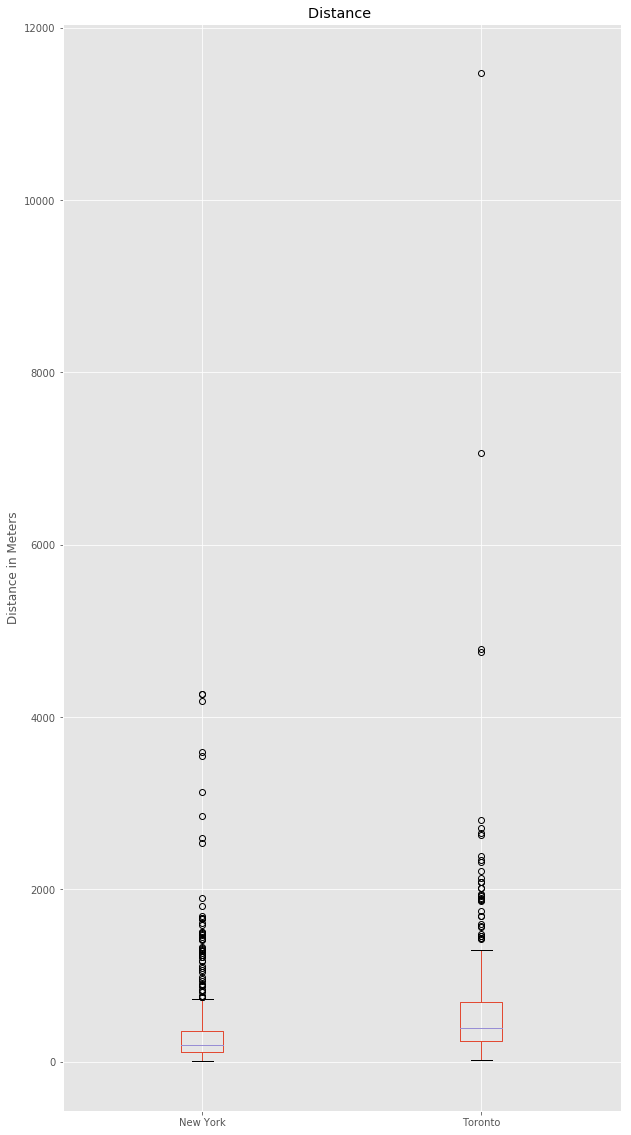

In [10]:
df_Box_Plot= df[['Distance','Location']]
df_Box_Plot.set_index("Location", inplace=True)
df_Box_TO=df_Box_Plot.loc['Toronto']
df_Box_NY=df_Box_Plot.loc['New York']
df_Box_TO=df_Box_TO.reset_index()
df_Box_NY=df_Box_NY.reset_index()
df_Box_TO=df_Box_TO.iloc[:,1].to_frame()
df_Box_NY=df_Box_NY.iloc[:,1].to_frame()
df_Box_TO.rename(columns={'Distance':'Toronto'}, inplace=True)
df_Box_NY.rename(columns={'Distance':'New York'}, inplace=True)
df_Box =df_Box_NY.join(df_Box_TO)
df_Box.plot(kind='box', figsize=(10, 20))
plt.title('Distance ')
plt.ylabel('Distance in Meters')
plt.show()

Removing ouliers for both cities

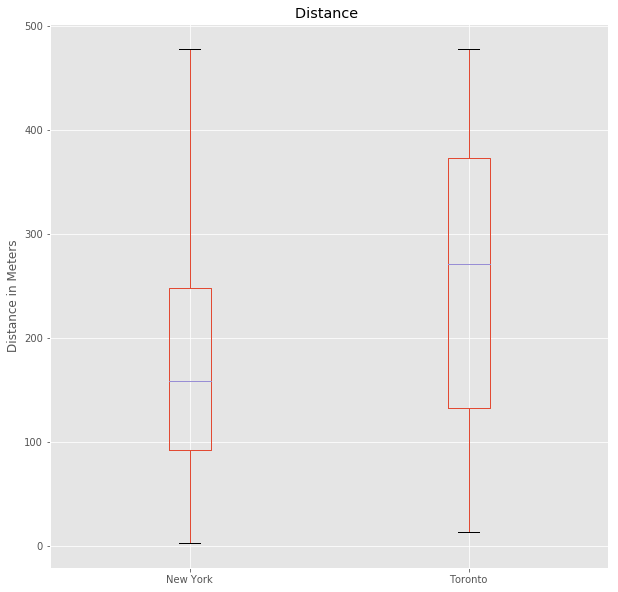

In [11]:
df_Box_Plot2= df[['Distance','Location']]
df_Box_Plot2=df_Box_Plot2[(df_Box_Plot2["Distance"] < 480)]
df_Box_Plot2.set_index("Location", inplace=True)
df_Box_TO2=df_Box_Plot2.loc['Toronto']
df_Box_NY2=df_Box_Plot2.loc['New York']
df_Box_TO2=df_Box_TO2.reset_index()
df_Box_NY2=df_Box_NY2.reset_index()
df_Box_TO2=df_Box_TO2.iloc[:,1].to_frame()
df_Box_NY2=df_Box_NY2.iloc[:,1].to_frame()
df_Box_TO2.rename(columns={'Distance':'Toronto'}, inplace=True)
df_Box_NY2.rename(columns={'Distance':'New York'}, inplace=True)
df_Box2 =df_Box_NY2.join(df_Box_TO2)
df_Box2.plot(kind='box', figsize=(10, 10))
plt.title('Distance ')
plt.ylabel('Distance in Meters')
plt.show()

### Cost : Analysing NewYork and Toronto Restaurants cost range using Pie chart

In [12]:
#Cost range percentage per Location
df_t_cost=df_t['Cost'].value_counts().to_frame()
df_n_cost=df_n['Cost'].value_counts().to_frame()
df_n_cost.rename(columns={'Cost':'New York'}, inplace=True)
df_t_cost.rename(columns={'Cost':'Toronto'}, inplace=True)
df_n_cost=round((df_n_cost/(df3.iloc[0,0]))*100,2)
df_t_cost=round((df_t_cost/(df_t_cost.sum()))*100,2)
df_cost =df_t_cost.join(df_n_cost)
df_cost=df_cost.transpose()
df_cost.rename(columns={1:'Cheap',2:'Moderate',3:'Expensive',4:'Very Expensive'}, inplace=True)
df_cost=df_cost[['Cheap','Moderate','Expensive','Very Expensive']].transpose()

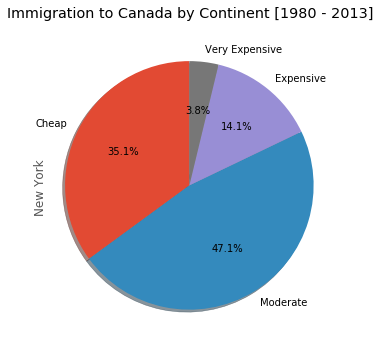

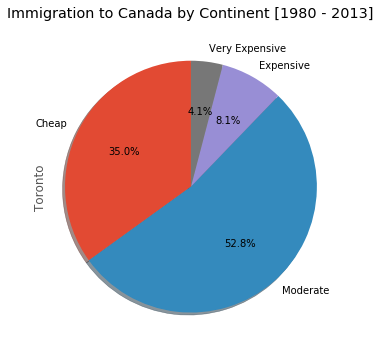

In [13]:
df_cost['New York'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Immigration to Canada by Continent [1980 - 2013]')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

df_cost['Toronto'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Immigration to Canada by Continent [1980 - 2013]')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

### Cost : Dataframe comparing NewYork and Toronto Expensive Restaurants density and distance to subway 

In [97]:
#The expensive cost % for New York is almost double (while is almost equal for the other cost brackets) compared to Toronto -- Let's investigate
df = pd.read_csv("Total_Restaurants.csv")
df_ex=df.set_index("Cost")
df_exp=df_ex.loc[[3,4]]
df_exp=df_exp[['Location','Distance','People/km2']]
df_exp=df_exp.set_index("Location")
Mean_exp=pd.DataFrame(
    {
        "City":["New York","Toronto"],
         "Distance Mean":[((df_exp.loc['New York']['Distance']).mean()),((df_exp.loc['Toronto']['Distance']).mean())],
        "Restaurant Number":[((df_exp.loc['New York']['Distance']).value_counts().count()),((df_exp.loc['Toronto']['Distance']).value_counts().count())],
        "Average Distance to Subway for expensive restaurants":[((df_exp.loc['New York']['Distance']).median()),((df_exp.loc['Toronto']['Distance']).median())],
        "Density Mean for Expensive Restaurants":[((df_exp.loc['New York']['People/km2']).mean()),((df_exp.loc['Toronto']['People/km2']).mean())],
    })
Mean_exp=Mean_exp.set_index("City")
Mean_exp.loc['New York','Average Distance to Subway for all Restaurants']=df3.loc['Average Distance to Subway(in m)','New York']
Mean_exp.loc['Toronto','Average Distance to Subway for all Restaurants']=df3.loc['Average Distance to Subway(in m)','Toronto']
Mean_exp.loc['New York','Density Mean for all Restaurants']=df3.loc['Density Average','New York']
Mean_exp.loc['Toronto','Density Mean for all Restaurants']=df3.loc['Density Average','Toronto']

Mean_exp=Mean_exp.transpose()
Mean_exp


City,New York,Toronto
Distance Mean,268.320312,511.266667
Restaurant Number,106.000000,41.000000
Average Distance to Subway for expensive restaurants,158.000000,410.000000
Density Mean for Expensive Restaurants,21065.960938,6832.471111
Average Distance to Subway for all Restaurants,335.260000,626.290000
Density Mean for all Restaurants,18144.400000,6119.100000


### Restaurant Type : Chart showing percentage of Restaurants where Restaurant Types are in common

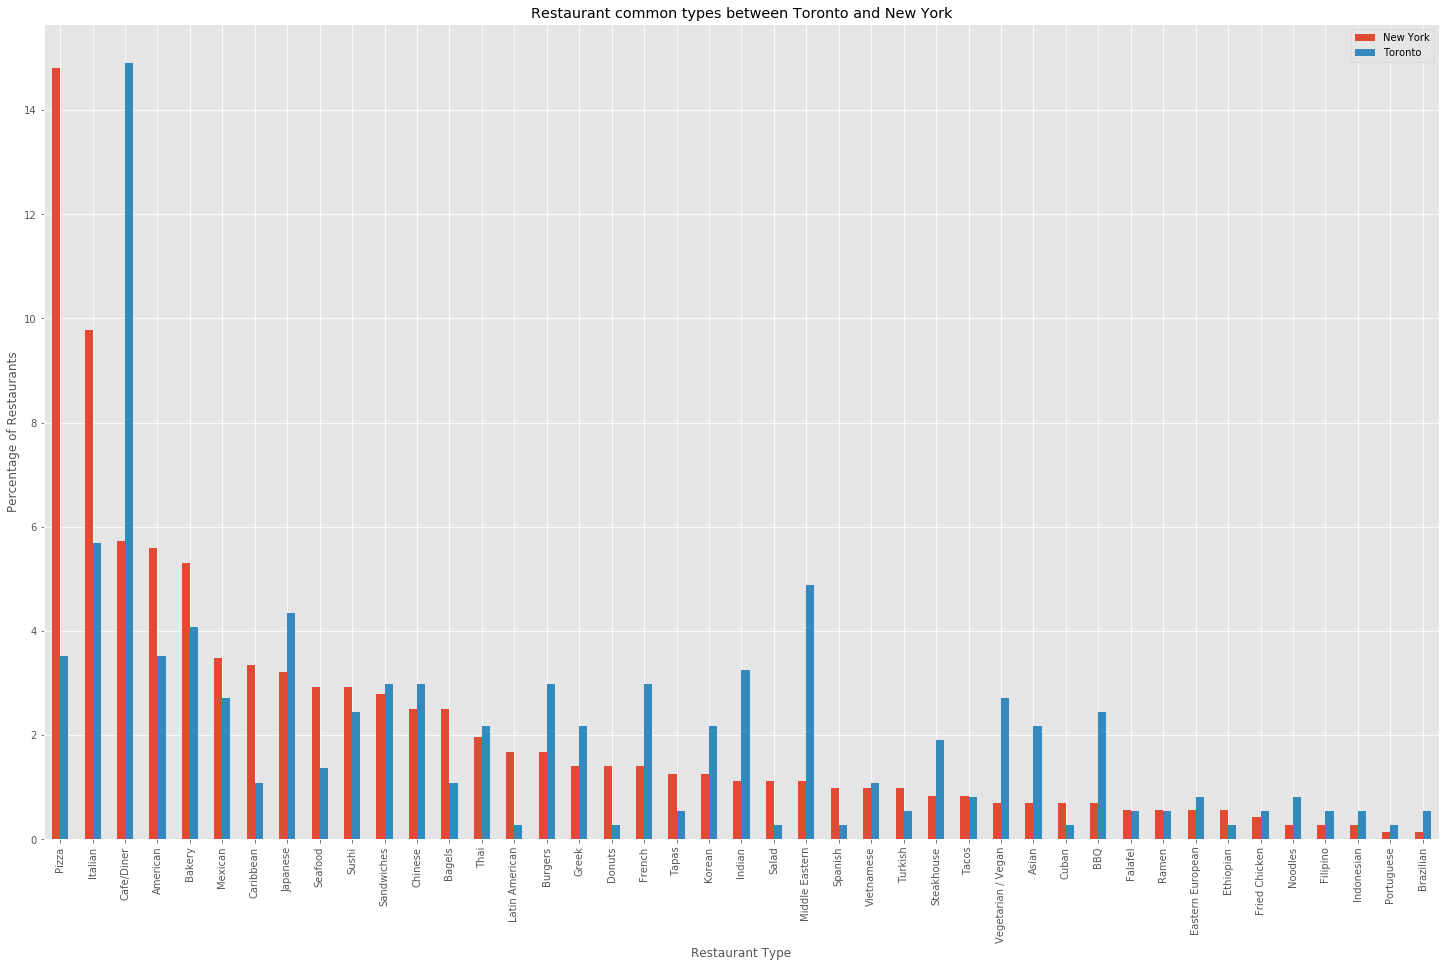

In [101]:
df_t_cat=df_t['Category'].value_counts().to_frame()
df_n_cat=df_n['Category'].value_counts().to_frame()
df_n_cat_index=df_n_cat.index
df_t_cat_index=df_t_cat.index
Common_Cat=df_n_cat_index.intersection(df_t_cat_index)
cat= pd.DataFrame()

for i in range(len(Common_Cat)):
    cat.loc[i,'Category']=Common_Cat[i]
    cat.loc[i,'New York']=round((((df_n_cat.loc[Common_Cat[i]][0])/(df_n_cat['Category'].sum()))*100),2)
    cat.loc[i,'Toronto']=round((((df_t_cat.loc[Common_Cat[i]][0])/(df_t_cat['Category'].sum()))*100),2)
cat.set_index("Category", inplace=True)

cat.plot(kind='bar', figsize=(25, 15))
plt.xlabel('Restaurant Type') # add to x-label to the plot
plt.ylabel('Percentage of Restaurants') # add y-label to the plot
plt.title('Restaurant common types between Toronto and New York') # add title to the plot
plt.show()

### Restaurant Type : Chart showing Count of Expensive Restaurants where Restaurant Types are in common 

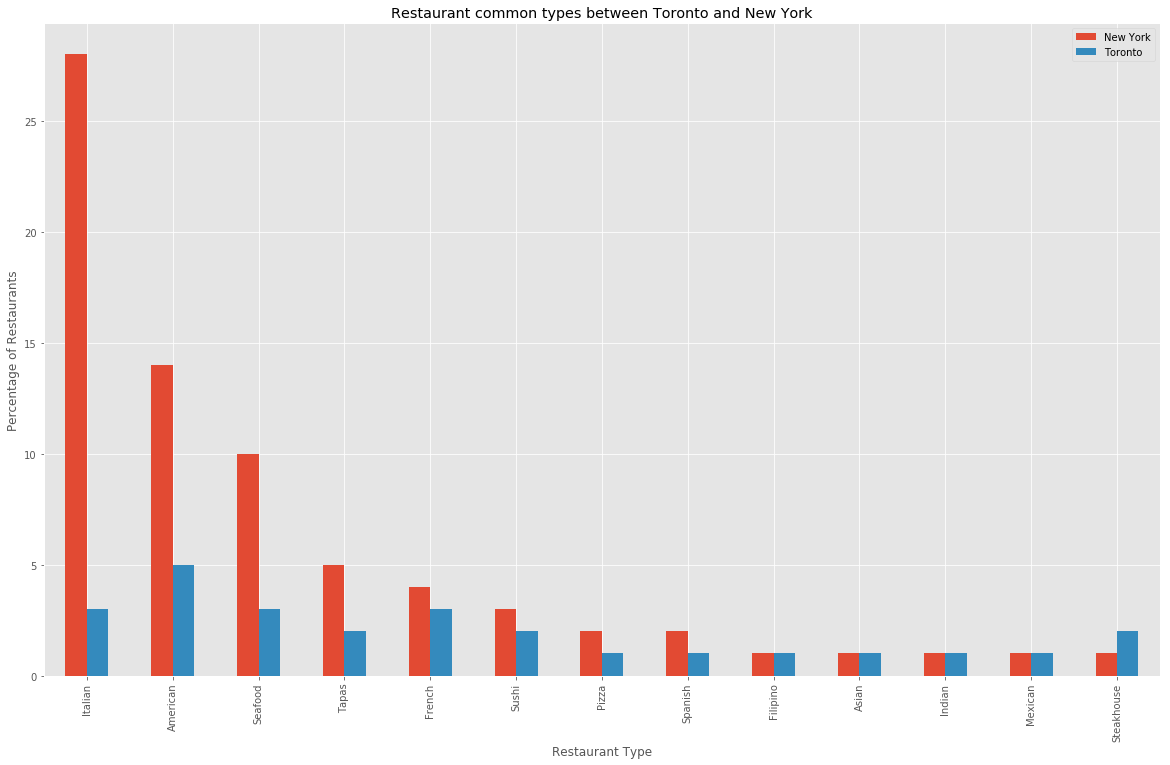

In [102]:
#Expensive restaurant type percentage between New York and Toronto
df = pd.read_csv("Total_Restaurants.csv")
df_Cost_Type=df[["Location","Category","Cost"]]
df_Cost_Type=df_Cost_Type.set_index("Cost")
df_Cost_Type=df_Cost_Type.loc[[3]]
df_Cost_Type=df_Cost_Type.reset_index()
df_Cost_TypeNY=df_Cost_Type.set_index('Location')
df_Cost_TypeTO=df_Cost_Type.set_index('Location')
df_Cost_TypeNY=df_Cost_TypeNY.loc['New York']
df_Cost_TypeTO=df_Cost_TypeTO.loc['Toronto']
df_Cost_TypeNY=df_Cost_TypeNY['Category'].value_counts().to_frame()
df_Cost_TypeNY.rename(columns={'Category':'New York'}, inplace=True)
df_Cost_TypeTO=df_Cost_TypeTO['Category'].value_counts().to_frame()
df_Cost_TypeTO.rename(columns={'Category':'Toronto'}, inplace=True)
df_Cost_Type=df_Cost_TypeNY.join(df_Cost_TypeTO)
df_Cost_Type=df_Cost_Type.dropna()

df_Cost_Type.plot(kind='bar', figsize=(20, 12))
plt.xlabel('Restaurant Type') # add to x-label to the plot
plt.ylabel('Percentage of Restaurants') # add y-label to the plot
plt.title('Restaurant common types between Toronto and New York') # add title to the plot
plt.show()


## Machine Learning <a name="ML"></a>

In [114]:
import itertools

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [115]:
df.head()

,Location,Name,Category,Address,Latitude,Longitude,PostalCode,ID,Cost,Rating,Distance,People/km2,Borough
0,New York,Del Frisco's Double Eagle Steakhouse,Steakhouse,1221 Avenue of the Americas,40.759410,-73.982220,10020,4b0c24fef964a520be3723e3,4,9.3,102,14.0,Manhattan
1,New York,Artie's Steak and Seafood,Italian,394 City Island Ave,40.849542,-73.787317,10464,4514ed4df964a520e5391fe3,4,8.1,4268,536.0,Bronx
2,New York,City Island Diner,Cafe/Diner,304 City Island Ave,40.847238,-73.786245,10464,4b87d10cf964a5206ecd31e3,1,8.1,4188,536.0,Bronx
3,New York,Seafood City,Seafood,459 City Island Ave,40.850967,-73.789778,10464,4aa04654f964a520f33e20e3,2,8.4,4264,536.0,Bronx
4,New York,Kennedy's,American,406 Bayside,40.561360,-73.920932,11697,4b92907ef964a520c00434e3,2,8.0,3128,784.0,Brooklyn


In [118]:
df1=df[["Category","Cost","Rating","Distance","People/km2","Location","Borough"]]
bor=df1.loc[df1.index,"Borough"].replace({'Manhattan':1,'Brooklyn':2,'Bronx':3,'Queens':4,"Central Toronto":1,
                                          "Scarborough":2,"North York":3,"East York":4,"Markham":5,"Etobicoke":6,
                                          "York":7})
Type=df1.loc[df1.index,"Category"].replace({'Pizza':1,'Cafe/Diner':2,'Italian':3,'Bakery':4,'American':5, 
                                           'Japanese':6,'Mexican':7, 'Sandwiches':8, 'Sushi':9, 'Chinese':10, 'Caribbean':11,
                                           'Middle Eastern':12, 'Seafood':13, 'Burgers':14, 'Bagels':15, 'Thai':16, 
                                           'French':17,'Indian':18, 'Greek':19, 'Deli ':20, 'Korean':21, 
                                           'Vegetarian / Vegan':22,'BBQ':23,'Latin American':24, 'Steakhouse':25, 'Asian':26, 
                                           'Tapas':27, 'Donuts':28,'Vietnamese':29, 'Gastropub':30, 'Salad':31, 'Tacos':32,'Turkish':33,
                                           'Spanish':34,'Dumplings':35, 'Eastern European':36, 'Ramen':37, 'Mediterranean':38, 'Falafel':39,
                                           'Cuban':40, 'Fried Chicken':41, 'Ethiopian':42, 'Southern':43, 'Noodles':44,
                                           'Burritos':45, 'Filipino':46, 'Fish & Chips':47, 'Venezuelan':48, 'Indonesian':49,
                                           'Brazilian':50, 'Food Court':51, 'Deli':52, 'Peruvian':53, 'Creperie':54, 'Cantonese':55,
                                           'Snacks':56, 'Soup':57, 'German':58, 'Portuguese':59, 'Argentinian':60, 'Austrian':61,
                                           'Russian':62, 'Israeli':63, 'Malay':64, 'Moroccan':65, 'Colombian':66, 'Sri Lankan':67,
                                           'South American':68, 'African':69, 'Afghan':70, 'Pie':71, 'Taiwanese':72, 'Burmese':73,
                                           'Pakistani':74, 'Australian':75, 'Mongolian':76, 'Uzbek':77})
                                           
df1.loc[df1.index,"Borough"]=bor
df1.loc[df1.index,"Category"]=Type
df1.set_index("Location", inplace=True)
df_MLTO=df1.loc["Toronto"]
df_MLNY=df1.loc["New York"]
df_MLTO=df_MLTO.reset_index()
df_MLNY=df_MLNY.reset_index()
df_MLTO = df_MLTO.drop(["Location"], axis=1)
df_MLNY = df_MLNY.drop(["Location"], axis=1)

In [119]:
df_MLNY.head()

,Category,Cost,Rating,Distance,People/km2,Borough
0,25,4,9.3,102,14.0,1
1,3,4,8.1,4268,536.0,3
2,2,1,8.1,4188,536.0,3
3,13,2,8.4,4264,536.0,3
4,5,2,8.0,3128,784.0,2


In [120]:
df_MLTO.head()

,Category,Cost,Rating,Distance,People/km2,Borough
0,23,2,8.4,869,1419.0,5
1,6,2,8.3,860,1419.0,5
2,21,2,8.9,888,1419.0,5
3,54,1,8.0,672,1419.0,5
4,4,1,7.8,790,1419.0,5


In [121]:
X = df_MLNY
V = df_MLTO
y = df_MLNY['Cost'].values
z = df_MLTO['Cost'].values
X= preprocessing.StandardScaler().fit(X).transform(X)
V= preprocessing.StandardScaler().fit(V).transform(V)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [124]:
#Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
V_train, V_test, z_train, z_test = train_test_split( V, z, test_size=0.2, random_state=4)

print ('New York Train set:', X_train.shape,  y_train.shape)
print ('New York Test set:', X_test.shape,  y_test.shape)
print ("")
print ('Toronto Train set:', V_train.shape,  z_train.shape)
print ('Toronto Test set:', V_test.shape,  z_test.shape)


New York Train set: (572, 6) (572,)
New York Test set: (144, 6) (144,)

Toronto Train set: (295, 6) (295,)
Toronto Test set: (74, 6) (74,)


In [125]:
from sklearn.neighbors import KNeighborsClassifier

In [128]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
neigh = KNeighborsClassifier(n_neighbors = k).fit(V_train,z_train)
zhat = neigh.predict(V_test)

#Accuracy Evaluation
from sklearn import metrics
print("New York Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("New York Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print ("")
print("Toronto Train set Accuracy: ", metrics.accuracy_score(z_train, neigh.predict(V_train)))
print("Toronto Test set Accuracy: ", metrics.accuracy_score(z_test, zhat))

New York Train set Accuracy:  0.9318181818181818
New York Test set Accuracy:  0.9722222222222222

Toronto Train set Accuracy:  0.9661016949152542
Toronto Test set Accuracy:  0.918918918918919


In [129]:
k = 6
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
neigh = KNeighborsClassifier(n_neighbors = k).fit(V_train,z_train)
zhat = neigh.predict(V_test)

#Accuracy Evaluation
from sklearn import metrics
print("New York Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("New York Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print ("")
print("Toronto Train set Accuracy: ", metrics.accuracy_score(z_train, neigh.predict(V_train)))
print("Toronto Test set Accuracy: ", metrics.accuracy_score(z_test, zhat))

New York Train set Accuracy:  0.9125874125874126
New York Test set Accuracy:  0.9583333333333334

Toronto Train set Accuracy:  0.9593220338983051
Toronto Test set Accuracy:  0.918918918918919




### New York

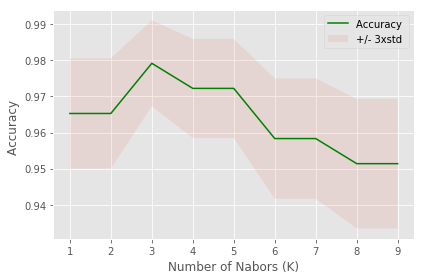

In [131]:
#calculate the accuracy of KNN for different Ks
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc
#Plot model accuracy for Different number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

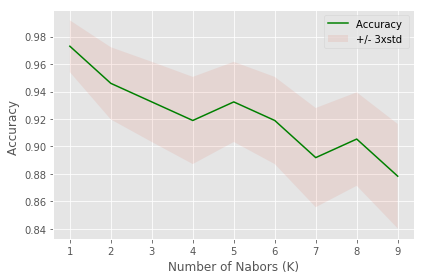

In [132]:
#calculate the accuracy of KNN for different Ks
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(V_train,z_train)
    zhat=neigh.predict(V_test)
    mean_acc[n-1] = metrics.accuracy_score(z_test, zhat)

    
    std_acc[n-1]=np.std(zhat==z_test)/np.sqrt(zhat.shape[0])

mean_acc
#Plot model accuracy for Different number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>